# Leukemia Classification Model (ALL vs AML)
This notebook builds a machine learning model to classify Acute Lymphoblastic Leukemia (ALL) vs Acute Myeloid Leukemia (AML)

In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [108]:
# Load the training data
train_data = pd.read_csv('data_set_ALL_AML_train.csv')
independent_data = pd.read_csv('data_set_ALL_AML_independent.csv')
actual_labels = pd.read_csv('actual.csv')

print(f"Training data shape: {train_data.shape}")
print(f"Independent data shape: {independent_data.shape}")
print(f"Actual labels shape: {actual_labels.shape}")
print("\nTraining data preview:")
print(train_data.head())
print(f"\nLabel distribution:\n{actual_labels['cancer'].value_counts()}")

Training data shape: (7129, 78)
Independent data shape: (7129, 70)
Actual labels shape: (72, 2)

Training data preview:
                      Gene Description Gene Accession Number    1 call    2  \
0  AFFX-BioB-5_at (endogenous control)        AFFX-BioB-5_at -214    A -139   
1  AFFX-BioB-M_at (endogenous control)        AFFX-BioB-M_at -153    A  -73   
2  AFFX-BioB-3_at (endogenous control)        AFFX-BioB-3_at  -58    A   -1   
3  AFFX-BioC-5_at (endogenous control)        AFFX-BioC-5_at   88    A  283   
4  AFFX-BioC-3_at (endogenous control)        AFFX-BioC-3_at -295    A -264   

  call.1    3 call.2    4 call.3  ...   29 call.33   30 call.34   31 call.35  \
0      A  -76      A -135      A  ...   15       A -318       A  -32       A   
1      A  -49      A -114      A  ... -114       A -192       A  -49       A   
2      A -307      A  265      A  ...    2       A  -95       A   49       A   
3      A  309      A   12      A  ...  193       A  312       A  230       P   
4    

## Dataset Overview and Statistics

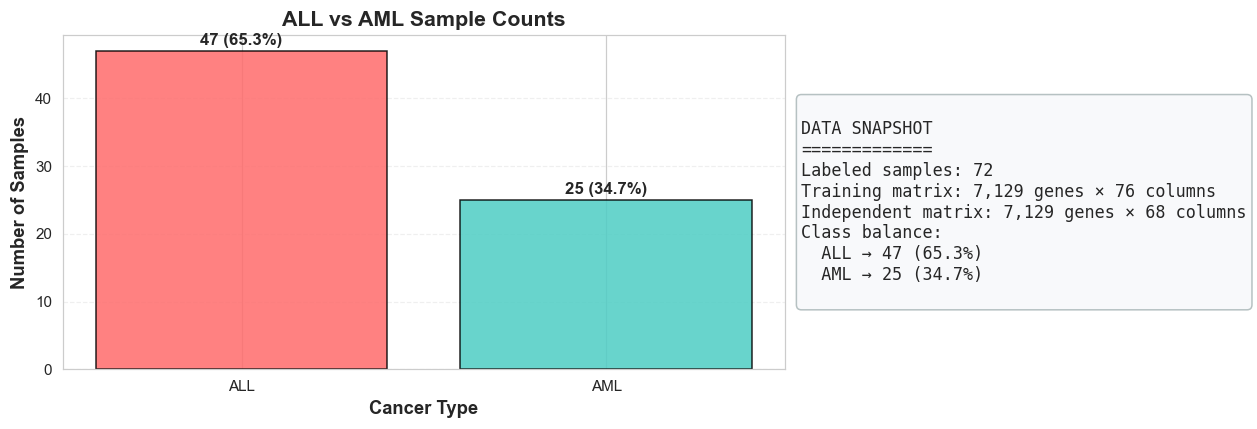

In [98]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 110

class_counts = actual_labels['cancer'].value_counts().sort_index()
fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [2, 1]})

bars = axes[0].bar(class_counts.index, class_counts.values, color=['#FF6B6B', '#4ECDC4'], edgecolor='black', alpha=0.85)
axes[0].set_xlabel('Cancer Type', fontsize=12, weight='bold')
axes[0].set_ylabel('Number of Samples', fontsize=12, weight='bold')
axes[0].set_title('ALL vs AML Sample Counts', fontsize=14, weight='bold')
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

for bar, (label, count) in zip(bars, class_counts.items()):
    pct = count / len(actual_labels) * 100
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{count} ({pct:.1f}%)',
                 ha='center', va='bottom', fontsize=11, weight='bold')

axes[1].axis('off')
summary_text = f"""
DATA SNAPSHOT
=============
Labeled samples: {len(actual_labels)}
Training matrix: {train_data.shape[0]:,} genes × {train_data.shape[1]-2:,} columns
Independent matrix: {independent_data.shape[0]:,} genes × {independent_data.shape[1]-2:,} columns
Class balance:
  {class_counts.index[0]} → {class_counts.iloc[0]} ({class_counts.iloc[0] / len(actual_labels) * 100:.1f}%)
  {class_counts.index[1]} → {class_counts.iloc[1]} ({class_counts.iloc[1] / len(actual_labels) * 100:.1f}%)
"""
axes[1].text(0.0, 0.5, summary_text, fontsize=11, ha='left', va='center', family='monospace',
             bbox=dict(boxstyle='round', facecolor='#F7F9FB', edgecolor='#AAB7B8', alpha=0.85))

plt.tight_layout()
plt.show()

## Data Preprocessing

In [99]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(actual_labels['cancer'])
print(f"Classes: {list(label_encoder.classes_)}")

# Helper to extract expression columns (drops metadata and detection call fields)
def extract_expression(df):
    expression_cols = [
        col for col in df.columns
        if col not in ['Gene Description', 'Gene Accession Number']
        and 'call' not in str(col).lower()
    ]
    return df[expression_cols]

# Get expression matrices from training and independent datasets
train_expression = extract_expression(train_data)
ind_expression = extract_expression(independent_data)

# Combine both datasets to align with the 72 labels provided
expression_combined = pd.concat([train_expression, ind_expression], axis=1)
expression_combined.index = train_data['Gene Description']

# Ensure samples are ordered according to the labels file
sample_ids = actual_labels['patient'].astype(str).tolist()
missing_samples = set(sample_ids) - set(expression_combined.columns)
if missing_samples:
    raise ValueError(f"Missing expression data for samples: {sorted(missing_samples)}")

expression_combined = expression_combined[sample_ids]

# Transpose so rows correspond to samples and columns to genes
X = expression_combined.T
X.index = actual_labels['patient'].astype(int)

print(f"\nExpression matrix shape (samples x genes): {X.shape}")
print(f"Labels shape: {y.shape}")

Classes: ['ALL', 'AML']

Expression matrix shape (samples x genes): (72, 7129)
Labels shape: (72,)


## Data Quality Analysis

C:\Users\siram\AppData\Local\Temp\ipykernel_17420\1247921330.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['ALL', 'AML'], patch_artist=True)
C:\Users\siram\AppData\Local\Temp\ipykernel_17420\1247921330.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['ALL', 'AML'], patch_artist=True)
C:\Users\siram\AppData\Local\Temp\ipykernel_17420\1247921330.py:30: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['ALL', 'AML'], patch_artist=True)
C:\Users\siram\AppData\Local\Temp\ipykernel_17420\1247921330.py:30: MatplotlibD

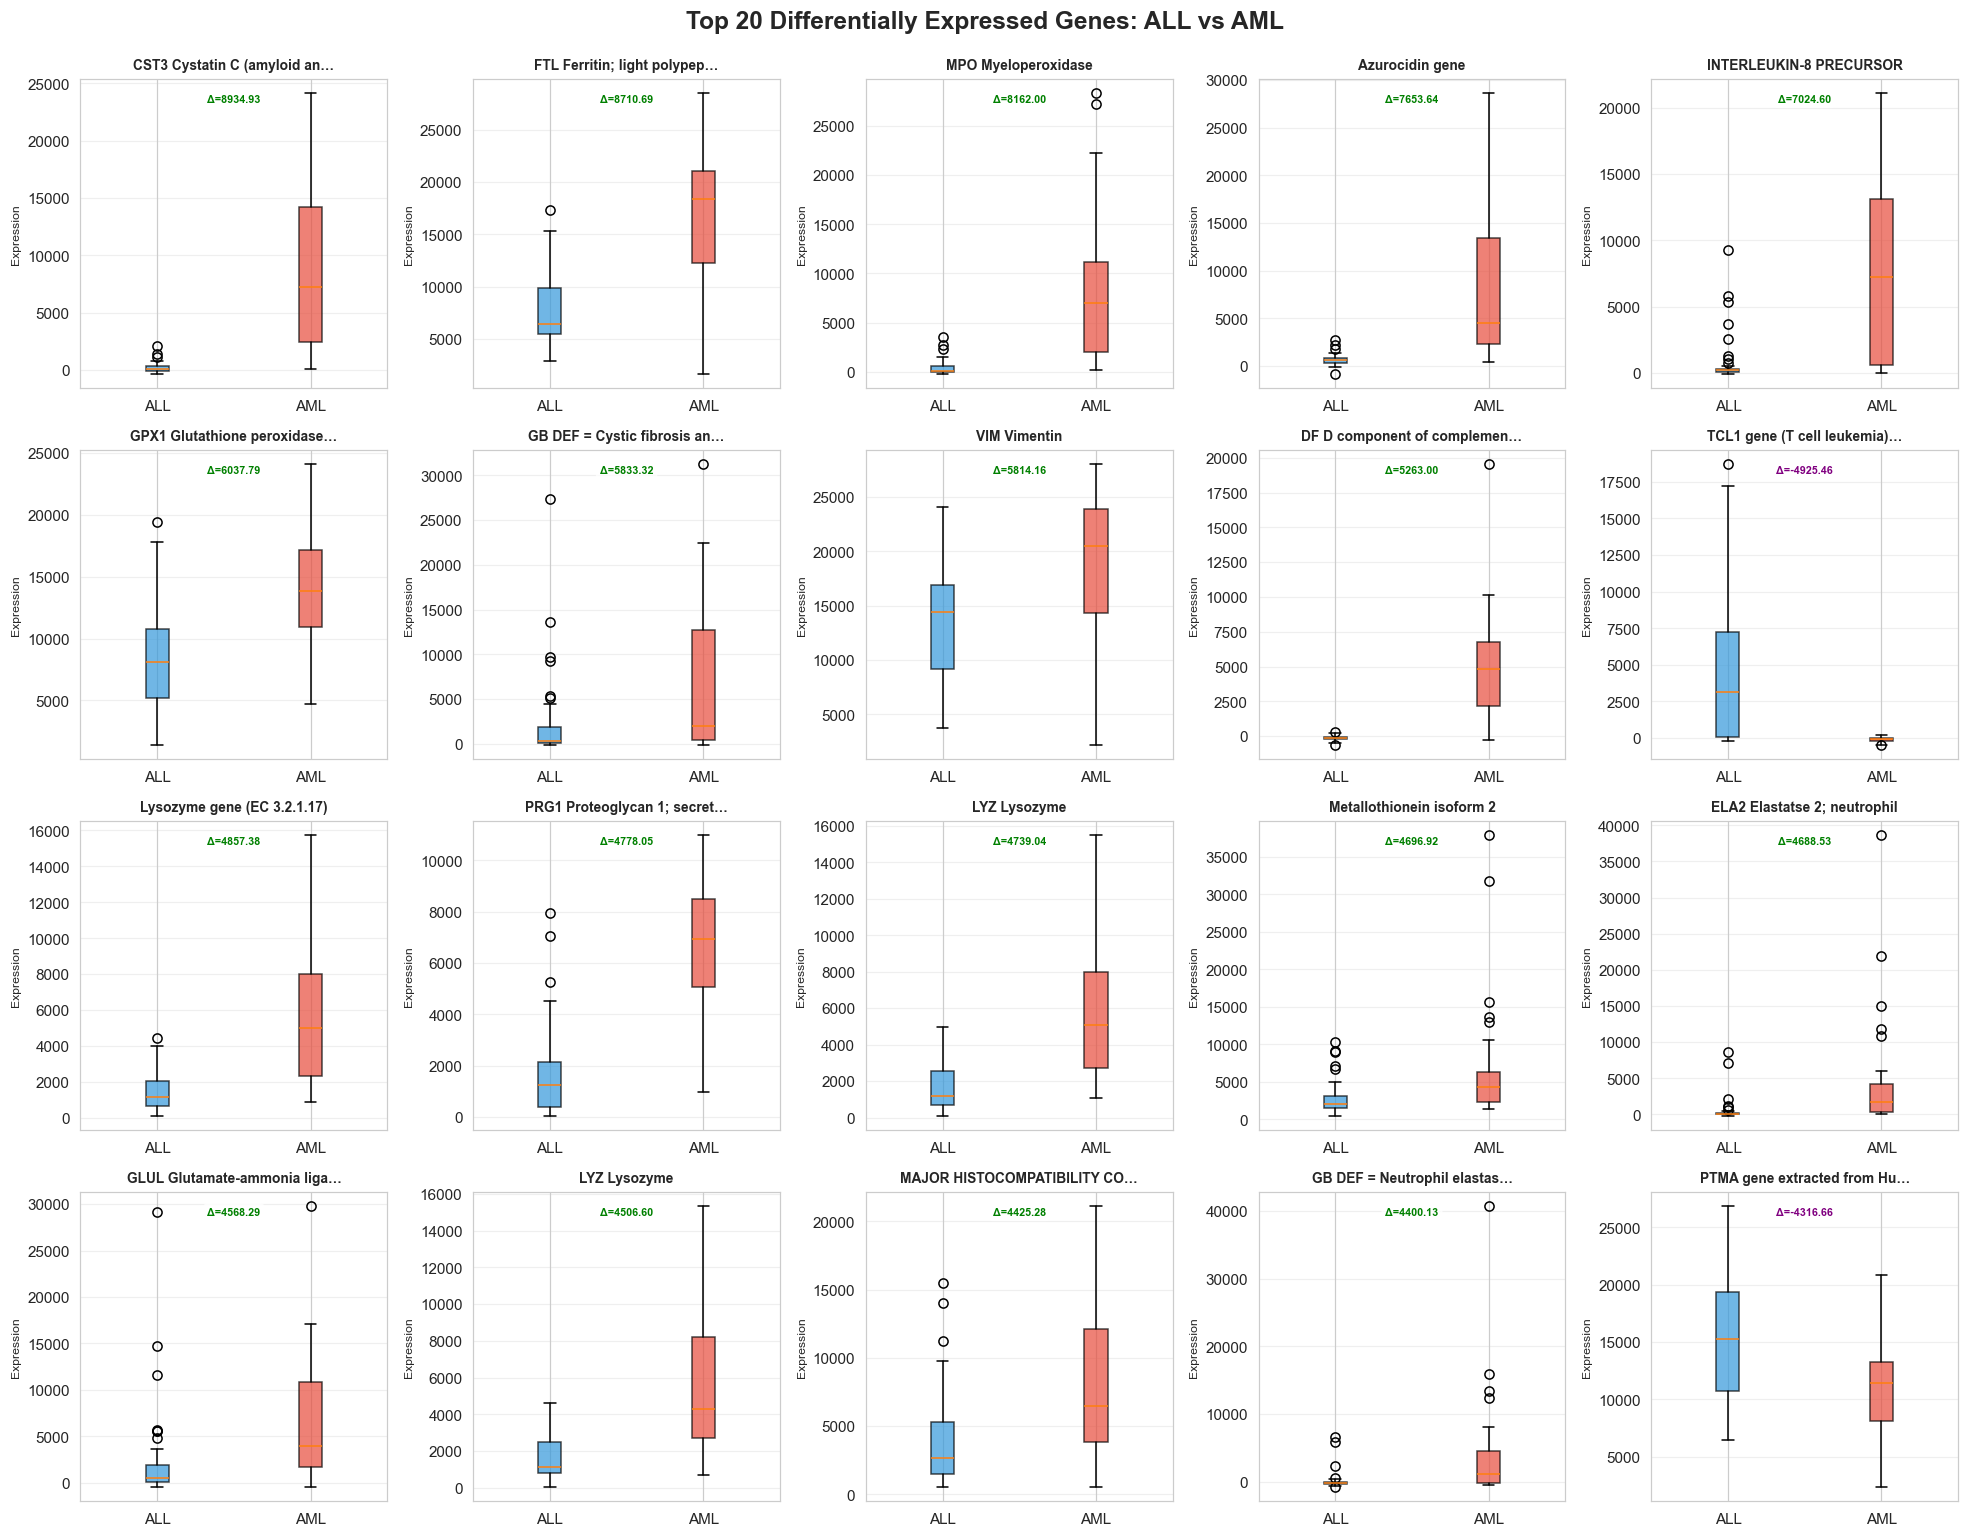


TOP 20 DIFFERENTIALLY EXPRESSED GENES
 1. CST3 Cystatin C (amyloid angiopathy and… | ALL mean:  185.47 | AML mean: 9120.40 | Diff: +8934.93
 2. FTL Ferritin; light polypeptide          | ALL mean: 7845.43 | AML mean: 16556.12 | Diff: +8710.69
 3. MPO Myeloperoxidase                      | ALL mean:  443.00 | AML mean: 8605.00 | Diff: +8162.00
 4. Azurocidin gene                          | ALL mean:  657.32 | AML mean: 8310.96 | Diff: +7653.64
 5. INTERLEUKIN-8 PRECURSOR                  | ALL mean:  766.28 | AML mean: 7790.88 | Diff: +7024.60
 6. GPX1 Glutathione peroxidase 1            | ALL mean: 8117.89 | AML mean: 14155.68 | Diff: +6037.79
 7. GB DEF = Cystic fibrosis antigen mRNA    | ALL mean: 2089.96 | AML mean: 7923.28 | Diff: +5833.32
 8. VIM Vimentin                             | ALL mean: 13171.40 | AML mean: 18985.56 | Diff: +5814.16
 9. DF D component of complement (adipsin)   | ALL mean: -137.72 | AML mean: 5125.28 | Diff: +5263.00
10. TCL1 gene (T cell leukemia) extract

In [100]:
# Visualization 5: Feature Expression Comparison Between Classes
# Prepare numpy arrays for efficient computation
X_array = X.to_numpy()
mask_ALL = (y == 0)
mask_AML = (y == 1)

# Select top 20 most differentially expressed genes between ALL and AML
sample_means_ALL = X_array[mask_ALL].mean(axis=0)
sample_means_AML = X_array[mask_AML].mean(axis=0)
mean_diff = np.abs(sample_means_ALL - sample_means_AML)
top_genes_idx = np.argsort(mean_diff)[-20:][::-1]

# Create subplots
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
axes = axes.flatten()

def shorten(label, max_len=28):
    return label if len(label) <= max_len else label[:max_len-1] + '…'

for i, gene_idx in enumerate(top_genes_idx):
    ax = axes[i]
    gene_name = X.columns[gene_idx]

    # Get expression values for this gene
    ALL_values = X_array[mask_ALL, gene_idx]
    AML_values = X_array[mask_AML, gene_idx]

    # Create box plot
    box_data = [ALL_values, AML_values]
    bp = ax.boxplot(box_data, labels=['ALL', 'AML'], patch_artist=True)

    # Color boxes
    bp['boxes'][0].set_facecolor('#3498db')
    bp['boxes'][1].set_facecolor('#e74c3c')
    bp['boxes'][0].set_alpha(0.7)
    bp['boxes'][1].set_alpha(0.7)

    # Style
    ax.set_title(shorten(gene_name), fontsize=9, weight='bold')
    ax.set_ylabel('Expression', fontsize=8)
    ax.grid(axis='y', alpha=0.3)

    # Add mean difference annotation
    mean_diff_val = sample_means_AML[gene_idx] - sample_means_ALL[gene_idx]
    color = 'green' if mean_diff_val > 0 else 'purple'
    ax.text(0.5, 0.95, f'Δ={mean_diff_val:.2f}', transform=ax.transAxes,
            ha='center', va='top', fontsize=7, color=color, weight='bold',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Hide any unused subplots (safety)
for j in range(len(top_genes_idx), len(axes)):
    axes[j].axis('off')

plt.suptitle('Top 20 Differentially Expressed Genes: ALL vs AML',
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Print top gene statistics
print("\n" + "="*80)
print("TOP 20 DIFFERENTIALLY EXPRESSED GENES")
print("="*80)
for rank, gene_idx in enumerate(top_genes_idx[:10], 1):  # Show top 10 in text
    gene_name = shorten(X.columns[gene_idx], max_len=40)
    all_mean = sample_means_ALL[gene_idx]
    aml_mean = sample_means_AML[gene_idx]
    diff = aml_mean - all_mean
    print(f"{rank:2d}. {gene_name:40s} | ALL mean: {all_mean:7.2f} | AML mean: {aml_mean:7.2f} | Diff: {diff:+7.2f}")
print("="*80)

## Split Data and Scale Features

In [101]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Training set: (50, 7129)
Test set: (22, 7129)


## Model 1: Random Forest Classifier

In [102]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluation
print("Random Forest Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_)}")

Random Forest Classifier Results:
Accuracy: 0.9091

Classification Report:
              precision    recall  f1-score   support

         ALL       0.88      1.00      0.93        14
         AML       1.00      0.75      0.86         8

    accuracy                           0.91        22
   macro avg       0.94      0.88      0.90        22
weighted avg       0.92      0.91      0.91        22



## Model 2: Support Vector Machine

In [103]:
# Train SVM
svm_model = SVC(kernel='rbf', random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test_scaled)

# Evaluation
print("SVM Classifier Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_)}")

SVM Classifier Results:
Accuracy: 0.8182

Classification Report:
              precision    recall  f1-score   support

         ALL       0.78      1.00      0.88        14
         AML       1.00      0.50      0.67         8

    accuracy                           0.82        22
   macro avg       0.89      0.75      0.77        22
weighted avg       0.86      0.82      0.80        22



## Comprehensive Model Comparison


MODEL PERFORMANCE COMPARISON
        Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Random Forest  0.909091   0.920455 0.909091  0.905628 0.964286
          SVM  0.818182   0.858586 0.818182  0.799242 0.910714


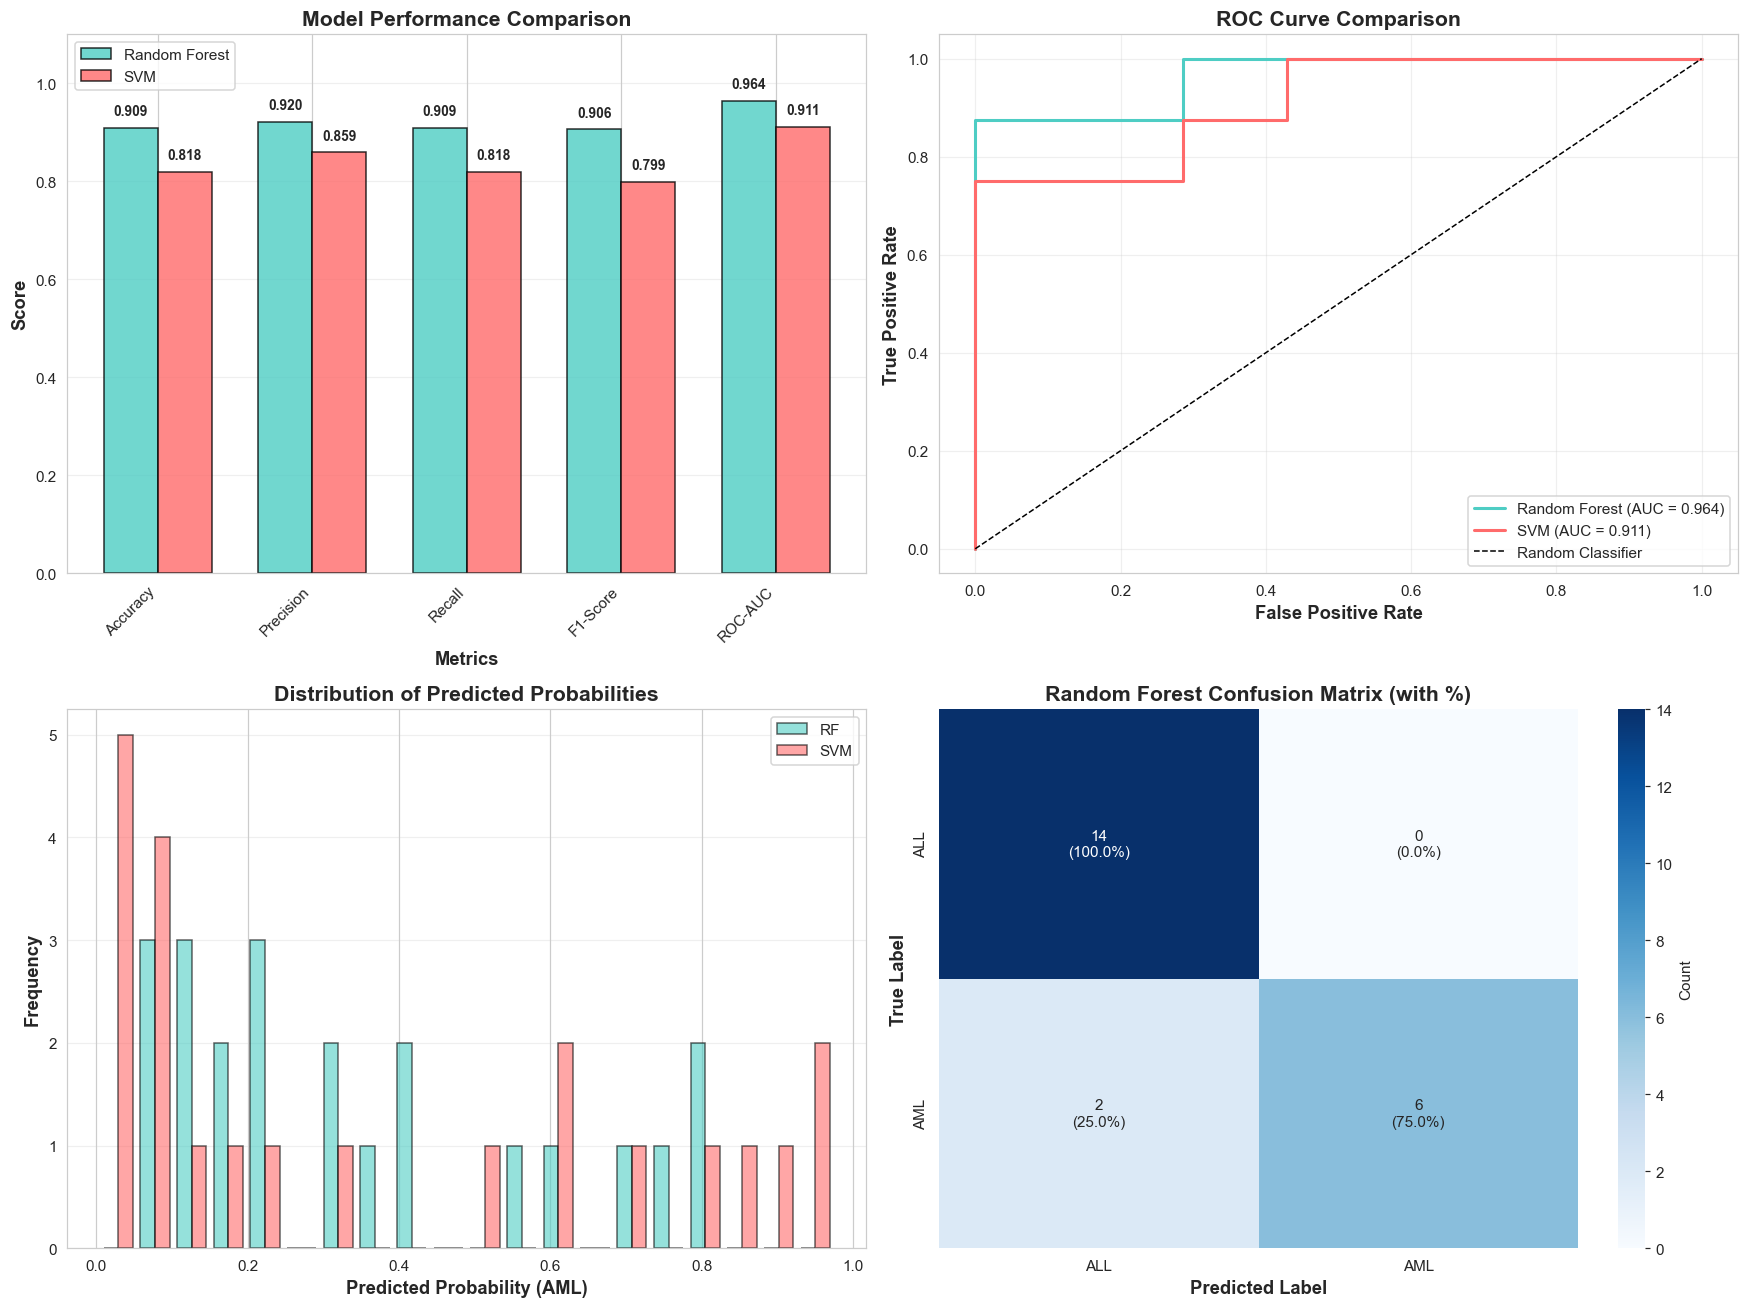

In [104]:
# Import additional metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Calculate metrics for both models
models_performance = {
    'Model': ['Random Forest', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
}

# Get probability predictions for ROC curve
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

models_performance['ROC-AUC'] = [
    roc_auc_score(y_test, y_pred_proba_rf),
    roc_auc_score(y_test, y_pred_proba_svm)
]

perf_df = pd.DataFrame(models_performance)

# Confusion matrices reused across visualizations for consistency
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_svm = confusion_matrix(y_test, y_pred_svm)

# Display performance table
print("\n" + "="*90)
print("MODEL PERFORMANCE COMPARISON")
print("="*90)
print(perf_df.to_string(index=False))
print("="*90)

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Performance metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.35

rf_scores = [perf_df.iloc[0][metric] for metric in metrics]
svm_scores = [perf_df.iloc[1][metric] for metric in metrics]

axes[0, 0].bar(x - width/2, rf_scores, width, label='Random Forest', 
               color='#4ECDC4', alpha=0.8, edgecolor='black')
axes[0, 0].bar(x + width/2, svm_scores, width, label='SVM', 
               color='#FF6B6B', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Metrics', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('Score', fontsize=12, weight='bold')
axes[0, 0].set_title('Model Performance Comparison', fontsize=14, weight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 1.1])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (rf_val, svm_val) in enumerate(zip(rf_scores, svm_scores)):
    axes[0, 0].text(i - width/2, rf_val + 0.02, f'{rf_val:.3f}', 
                    ha='center', va='bottom', fontsize=9, weight='bold')
    axes[0, 0].text(i + width/2, svm_val + 0.02, f'{svm_val:.3f}', 
                    ha='center', va='bottom', fontsize=9, weight='bold')

# ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm)

axes[0, 1].plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba_rf):.3f})',
                color='#4ECDC4')
axes[0, 1].plot(fpr_svm, tpr_svm, linewidth=2, label=f'SVM (AUC = {roc_auc_score(y_test, y_pred_proba_svm):.3f})',
                color='#FF6B6B')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12, weight='bold')
axes[0, 1].set_title('ROC Curve Comparison', fontsize=14, weight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(alpha=0.3)

# Prediction distribution
axes[1, 0].hist([y_pred_proba_rf, y_pred_proba_svm], bins=20, label=['RF', 'SVM'],
                color=['#4ECDC4', '#FF6B6B'], alpha=0.6, edgecolor='black')
axes[1, 0].set_xlabel('Predicted Probability (AML)', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Frequency', fontsize=12, weight='bold')
axes[1, 0].set_title('Distribution of Predicted Probabilities', fontsize=14, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Confusion matrices side by side with percentages
cm_rf_pct = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis] * 100
cm_svm_pct = cm_svm.astype('float') / cm_svm.sum(axis=1)[:, np.newaxis] * 100

labels_rf = [[f'{val}\n({pct:.1f}%)' for val, pct in zip(row_vals, row_pcts)] 
             for row_vals, row_pcts in zip(cm_rf, cm_rf_pct)]
labels_svm = [[f'{val}\n({pct:.1f}%)' for val, pct in zip(row_vals, row_pcts)] 
              for row_vals, row_pcts in zip(cm_svm, cm_svm_pct)]

sns.heatmap([[cm_rf[0,0], cm_rf[0,1]], [cm_rf[1,0], cm_rf[1,1]]], 
            annot=labels_rf, fmt='', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
            ax=axes[1, 1], cbar_kws={'label': 'Count'})
axes[1, 1].set_title('Random Forest Confusion Matrix (with %)', fontsize=14, weight='bold')
axes[1, 1].set_ylabel('True Label', fontsize=12, weight='bold')
axes[1, 1].set_xlabel('Predicted Label', fontsize=12, weight='bold')

plt.tight_layout()
plt.show()

## Confusion Matrix Visualization

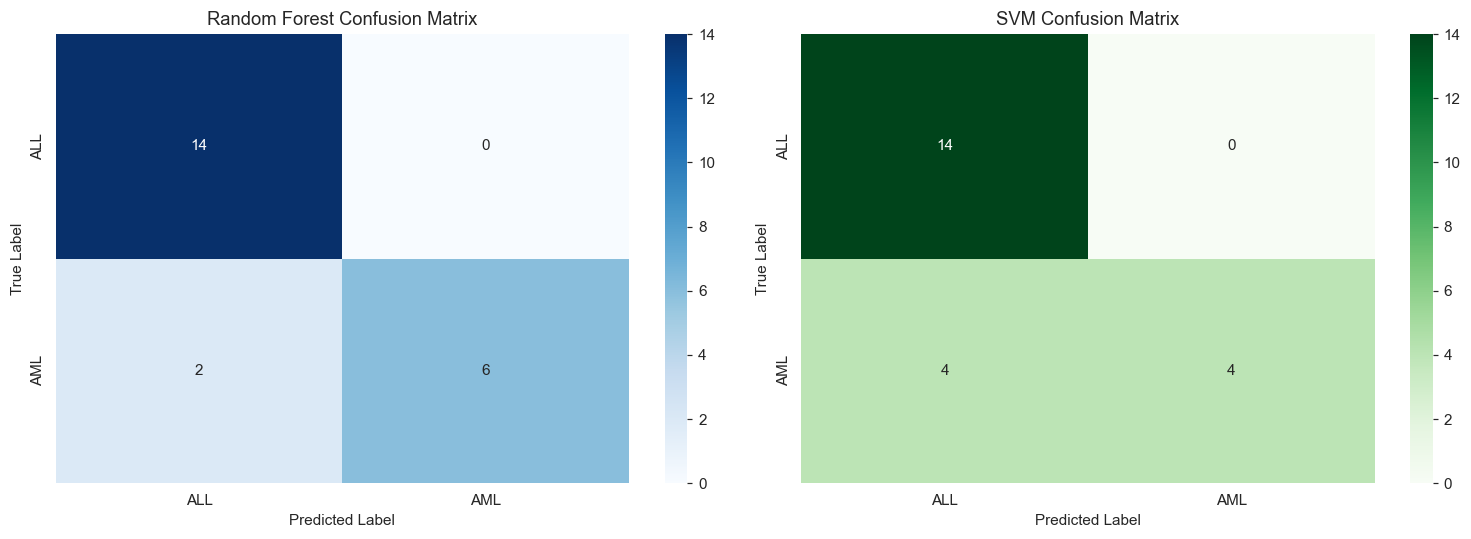

In [105]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# SVM confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_, ax=axes[1])
axes[1].set_title('SVM Confusion Matrix')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## Feature Importance (Random Forest)

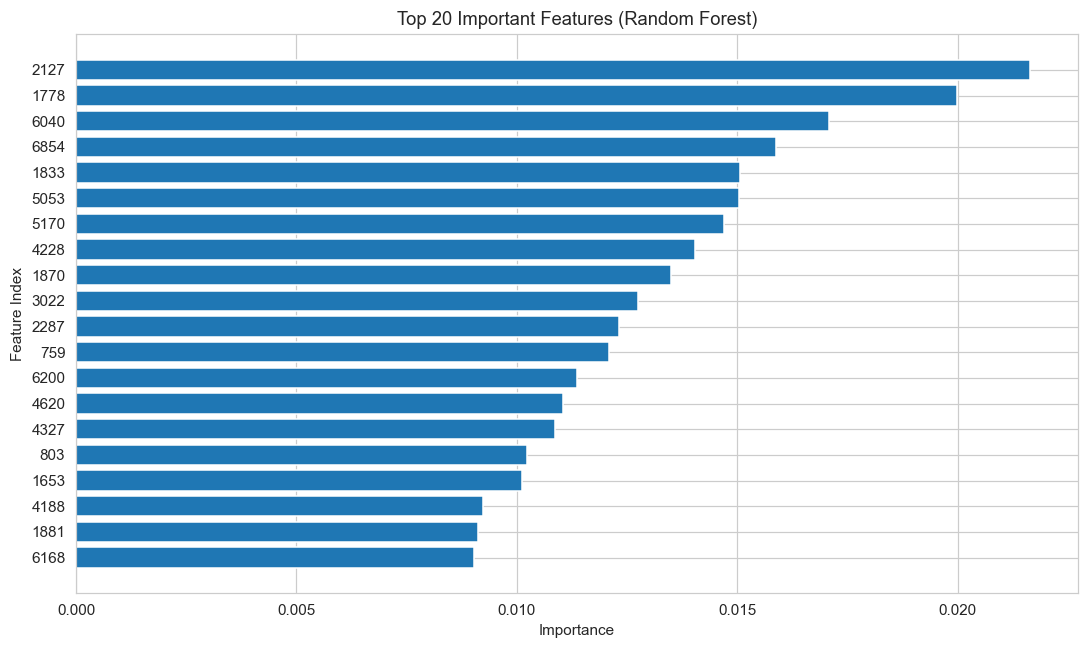

In [106]:
# Get top 20 important features
feature_importance = pd.DataFrame({
    'feature': range(X_train.shape[1]),
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance')
plt.ylabel('Feature Index')
plt.title('Top 20 Important Features (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Advanced Feature Analysis and Final Summary

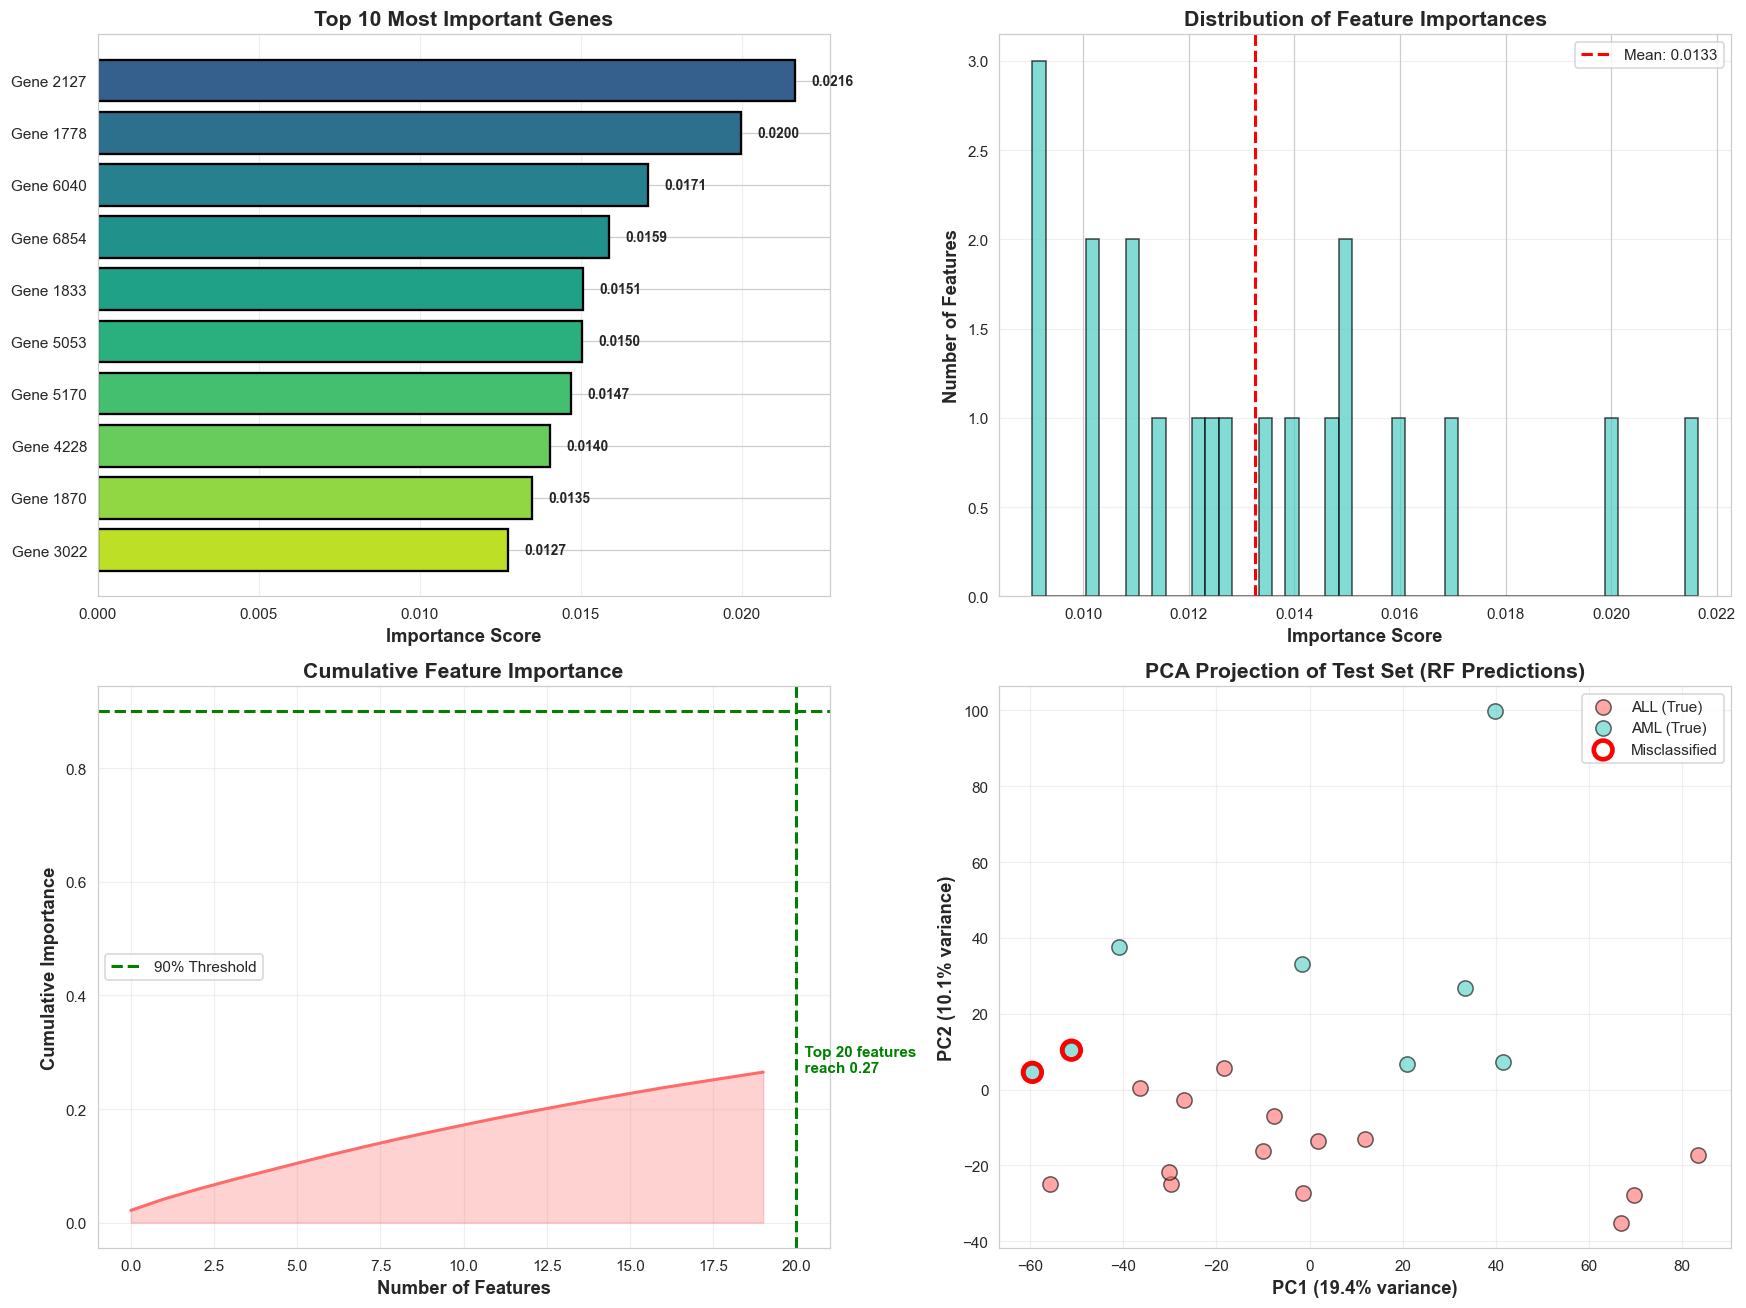


FINAL MODEL SUMMARY AND RECOMMENDATIONS

✓ Best Performing Model: Random Forest
✓ Best Accuracy: 0.9091
✓ Best ROC-AUC: 0.9643

✓ Top feature set covers 26.5% cumulative importance (90% not reached)
✓ Feature reduction potential: 99.7%

✓ Total samples analyzed: 72
✓ Training samples: 50
✓ Test samples: 22

✓ Misclassifications (RF): 2 out of 22
✓ Misclassifications (SVM): 4 out of 22

COMPLETE FEATURE IMPORTANCE RANKING
Gene 2127.0: 0.021644
Gene 1778.0: 0.019973
Gene 6040.0: 0.017078
Gene 6854.0: 0.015868
Gene 1833.0: 0.015064
Gene 5053.0: 0.015043
Gene 5170.0: 0.014695
Gene 4228.0: 0.014048
Gene 1870.0: 0.013488
Gene 3022.0: 0.012748
Gene 2287.0: 0.012322
Gene 759.0: 0.012098
Gene 6200.0: 0.011355
Gene 4620.0: 0.011045
Gene 4327.0: 0.010857
Gene 803.0: 0.010230
Gene 1653.0: 0.010110
Gene 4188.0: 0.009230
Gene 1881.0: 0.009107
Gene 6168.0: 0.009035


In [107]:
# Comprehensive feature analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Ensure we have consistent column names for downstream analysis
fi_extended = feature_importance.rename(columns={
    'feature': 'Feature',
    'importance': 'Importance'
}).copy()

# Top 10 most important features with better visualization
top_features = fi_extended.nlargest(10, 'Importance')
colors_gradient = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))

axes[0, 0].barh(range(len(top_features)), top_features['Importance'], 
                color=colors_gradient, edgecolor='black', linewidth=1.5)
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels([f'Gene {idx}' for idx in top_features['Feature']])
axes[0, 0].set_xlabel('Importance Score', fontsize=12, weight='bold')
axes[0, 0].set_title('Top 10 Most Important Genes', fontsize=14, weight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Add value labels
for i, (_, row) in enumerate(top_features.iterrows()):
    axes[0, 0].text(row['Importance'] + 0.0005, i, f"{row['Importance']:.4f}", 
                    va='center', fontsize=9, weight='bold')

# Feature importance distribution
axes[0, 1].hist(fi_extended['Importance'], bins=50, color='#4ECDC4', 
                edgecolor='black', alpha=0.7)
axes[0, 1].axvline(fi_extended['Importance'].mean(), color='red', 
                   linestyle='--', linewidth=2, label=f'Mean: {fi_extended["Importance"].mean():.4f}')
axes[0, 1].set_xlabel('Importance Score', fontsize=12, weight='bold')
axes[0, 1].set_ylabel('Number of Features', fontsize=12, weight='bold')
axes[0, 1].set_title('Distribution of Feature Importances', fontsize=14, weight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Cumulative importance
sorted_importance = np.sort(fi_extended['Importance'].values)[::-1]
cumsum_importance = np.cumsum(sorted_importance)
axes[1, 0].plot(range(len(cumsum_importance)), cumsum_importance, 
                linewidth=2, color='#FF6B6B')
axes[1, 0].axhline(y=0.9, color='green', linestyle='--', linewidth=2, 
                   label='90% Threshold')
axes[1, 0].fill_between(range(len(cumsum_importance)), cumsum_importance, 
                         alpha=0.3, color='#FF6B6B')
axes[1, 0].set_xlabel('Number of Features', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Cumulative Importance', fontsize=12, weight='bold')
axes[1, 0].set_title('Cumulative Feature Importance', fontsize=14, weight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

threshold = 0.9
if len(cumsum_importance) == 0:
    n_features_90 = 0
    threshold_reached = False
elif cumsum_importance[-1] >= threshold:
    n_features_90 = int(np.searchsorted(cumsum_importance, threshold)) + 1
    threshold_reached = True
else:
    n_features_90 = len(cumsum_importance)
    threshold_reached = False

if n_features_90 > 0:
    axes[1, 0].axvline(x=n_features_90, color='green', linestyle='--', linewidth=2)
    label_text = (f'  {n_features_90} features\n  for 90% importance'
                  if threshold_reached else
                  f'  Top {n_features_90} features\n  reach {cumsum_importance[-1]:.2f}')
    axes[1, 0].text(n_features_90, min(cumsum_importance[-1], 0.5), label_text,
                    fontsize=10, weight='bold', color='green')

# Model decision boundary visualization (using PCA for 2D projection)
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)

scatter_all = axes[1, 1].scatter(X_test_pca[y_test==0, 0], X_test_pca[y_test==0, 1], 
                                 c='#FF6B6B', label='ALL (True)', alpha=0.6, s=100,
                                 edgecolors='black', linewidth=1)
scatter_aml = axes[1, 1].scatter(X_test_pca[y_test==1, 0], X_test_pca[y_test==1, 1], 
                                 c='#4ECDC4', label='AML (True)', alpha=0.6, s=100,
                                 edgecolors='black', linewidth=1)

# Mark misclassifications
misclassified = y_test != y_pred_rf
axes[1, 1].scatter(X_test_pca[misclassified, 0], X_test_pca[misclassified, 1],
                   c='none', edgecolors='red', linewidths=3, s=150, 
                   label='Misclassified', marker='o')

axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
                      fontsize=12, weight='bold')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
                      fontsize=12, weight='bold')
axes[1, 1].set_title('PCA Projection of Test Set (RF Predictions)', fontsize=14, weight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary report
print("\n" + "="*90)
print("FINAL MODEL SUMMARY AND RECOMMENDATIONS")
print("="*90)
print(f"\n✓ Best Performing Model: {perf_df.loc[perf_df['Accuracy'].idxmax(), 'Model']}")
print(f"✓ Best Accuracy: {perf_df['Accuracy'].max():.4f}")
print(f"✓ Best ROC-AUC: {perf_df['ROC-AUC'].max():.4f}")

if threshold_reached:
    coverage_text = f"✓ Number of features needed for 90% importance: {n_features_90} out of {X.shape[1]}"
else:
    coverage_text = ("✓ Top feature set covers "
                     f"{cumsum_importance[-1]*100:.1f}% cumulative importance (90% not reached)")
print(f"\n{coverage_text}")
print(f"✓ Feature reduction potential: {((X.shape[1] - n_features_90) / X.shape[1] * 100):.1f}%")
print(f"\n✓ Total samples analyzed: {len(y)}")
print(f"✓ Training samples: {len(y_train)}")
print(f"✓ Test samples: {len(y_test)}")
print(f"\n✓ Misclassifications (RF): {(y_test != y_pred_rf).sum()} out of {len(y_test)}")
print(f"✓ Misclassifications (SVM): {(y_test != y_pred_svm).sum()} out of {len(y_test)}")
print("="*90)

# Detailed feature importance listing
print("\n" + "="*90)
print("COMPLETE FEATURE IMPORTANCE RANKING")
print("="*90)
for _, row in fi_extended.sort_values('Importance', ascending=False).iterrows():
    print(f"Gene {row['Feature']:>5}: {row['Importance']:.6f}")
print("="*90)